In [469]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('../../', os.path.abspath('')))

import dill as pickle
from pyseir.load_data import *
from pyseir.utils import REF_DATE
from datetime import timedelta
from pyseir.testing.test_strategy_simulator import TestStrategySimulator
from pyseir.testing.plots import *
from pyseir.inference.fit_results import load_Rt_result
import seaborn as sns
import matplotlib.pyplot as plt
from pyseir.testing.load_data import load_projection, load_rt
from pyseir.inference.infer_rt import run_state as run_rt_inference
from pyseir.deployment.demographic_mapper import DemographicMapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Get demographic mapper result

Assuming demographic mapper result and Rt inference are ready...

Assuming following data for a worksite (lots of wild assumptions ...)
- population size at worksite: 5000
- PCR cost per individual = 250
- PCR sensitivity (P(positive PCR | infected)) = 0.7
- Antibody test cost per individual = 120
- Antibody test sensitivity on detecting immunity (P(positive Antibody | immune)) = 0.5
- Max PCR availability per month = population size at worksite
- Max antibody test availability (distributed before worksite re-open) = population size at worksite
- Mininum number of cases for outbreak per month = 5
- Cost of hospitalization due to covid = 3000 
- Frac of contact(ppl) that will be active at site (fraction of worker back to worksite at first, worker with antibody   test positive gets priority)   = 0.5
- Cost of worksite closure = 200000
- PCR test always starts at beginning of the month.

In [18]:
FIPS = '06'

### Infer Rt

In [ ]:
run_rt_inference(state=FIPS, states_only=True)

In [20]:
Rt = load_rt(FIPS)

### Run testing strategy simulation

#### Scenario I. Optimal pcr coverage and frequency at a given budget

**Assuming budget for pcr test is $500000 per month**

In [474]:
max_pcr_cost_per_month = 500000

In [475]:
ts = TestStrategySimulator(fips=FIPS, 
                           antibody_coverage = [1],
                           date=Rt.index[-1],
                           pcr_frequency=[1, 2, 3, 4, 8, 15, 30],
                           max_pcr_cost_per_month=max_pcr_cost_per_month)

ts.run()
optimized = ts.optimize(by=['outbreak_prob', 'delta_p_infected'])
params, metrics = ts.reformat_optimization_results(optimized)

#### Optimal testing parameters and metrics

In [476]:
params

,optimal
antibody_coverage,1.0
pcr_coverage per month,0.1
pcr_frequency per month,4.0


In [477]:
metrics

,metrics
delta_p_infected per month,0.000871
prevented_secondary_transmission per month,3.395755
delta_covid_index per month,0.000021
test_cost_pcr per month,500000.000000
prevalence_given_testing per month,0.001692
outbreak_prob per month,0.471547
delta_outbreak_prob per month,0.508999
saved_cost_of_site_closure per month,508998.636576
avoided_cost per month,509320.853414


#### Scenario II. Optimal pcr coverage and frequency at a given budget

In [533]:
pcr_test_costs_per_month = np.linspace(500000, 1000000, 5)
test_results_list = list()

for freq in [1, 2, 4, 8]:
    pcr_covs = list()
    pcr_freqs = list()
    ab_covs = list()
    outbreak_prob = list()
    pcr_test_cost = list()
    
    for max_pcr_cost_per_month in pcr_test_costs_per_month:
        ts = TestStrategySimulator(fips=FIPS, 
                                   antibody_coverage = [1],
                                   date=Rt.index[-1],
                                   pcr_coverage=np.linspace(0, 1, 1000),
                                   pcr_frequency=[freq],
                                   max_pcr_cost_per_month=max_pcr_cost_per_month,
                                   )

        ts.run()
        optimized = ts.optimize(by=['outbreak_prob', 'test_cost_pcr'])
        pcr_covs.append(optimized['pcr_coverage']) 
        ab_covs.append(optimized['antibody_coverage'])
        outbreak_prob.append(optimized['outbreak_prob'])
        results.append(ts.results)
    
    test_results = pd.DataFrame({'pcr_coverage': pcr_covs,
                                 'outbreak_prob': outbreak_prob,
                                 'pcr frequency per month': [freq] * len(pcr_covs),
                                 'pcr_test_budget': pcr_test_costs_per_month})
    
    test_results_list.append(test_results)

test_results = pd.concat(test_results_list)

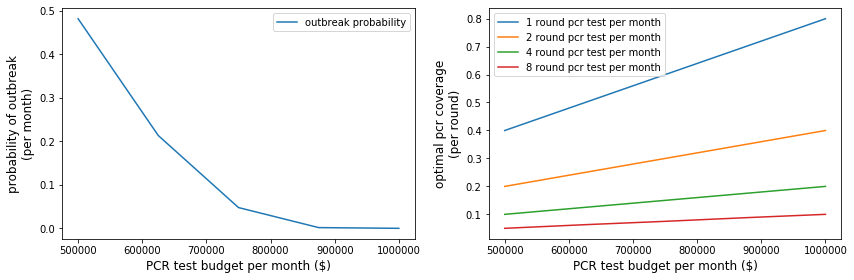

In [550]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# optimal outbreak probability
test_results_optimal_outbreak_prob = test_results.groupby('pcr_test_budget')['outbreak_prob'].min().reset_index()
test_results_optimal_outbreak_prob.plot(x='pcr_test_budget', y='outbreak_prob', ax=axes[0], label='outbreak probability')
axes[0].set_ylabel('probability of outbreak\n(per month)', fontsize=12)


# optimal pcr frequency
for freq in test_results['pcr frequency per month'].unique():
    test_results[test_results['pcr frequency per month'] == freq].plot(
        x='pcr_test_budget', y='pcr_coverage', ax=axes[1], label=f'{freq} round pcr test per month')

axes[1].set_ylabel('optimal pcr coverage\n(per round)', fontsize=12)

axes[0].set_xlabel('PCR test budget per month ($)', fontsize=12)
axes[1].set_xlabel('PCR test budget per month ($)', fontsize=12)


fig.tight_layout()
plt.show()

#### Scenario III. Saved Cost associated with worksite closure given different levels of testing

Text(0.5, 1.0, 'saved cost associated with worksite closure ($)')

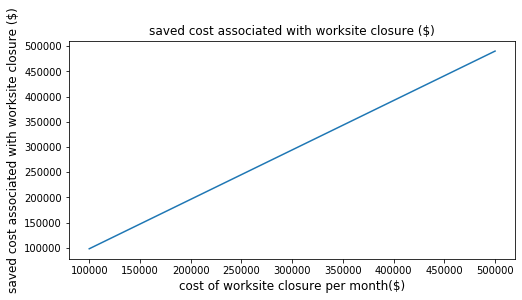

In [552]:
site_closure_costs = [100000, 200000, 300000, 500000]
delta_cost_worksite_closure = list()
net_costs = list()
for site_closure_cost in site_closure_costs:
    ts = TestStrategySimulator(fips=FIPS, 
                               antibody_coverage=[1],
                               pcr_coverage=[1],
                               pcr_frequency=[1], 
                               date=Rt.index[-1],
                               site_closure_cost=site_closure_cost,
                               max_pcr_cost_per_month=np.inf)

    ts.run()
    delta_cost_worksite_closure.append(ts.results['saved_cost_of_site_closure'].iloc[0])
    net_costs.append(ts.results['net_cost'].iloc[0])
    
    
    
plt.figure(figsize=(8, 4))
plt.plot(site_closure_costs,
         delta_cost_worksite_closure,
         label=f'pcr test {freq} times per month')
plt.xlabel('cost of worksite closure per month($)', fontsize=12)
plt.ylabel('saved cost associated with worksite closure ($)',
          fontsize=12)
plt.title('saved cost associated with worksite closure ($)')